# Import Modules

## Standard Packages

In [1]:
import os
import sys
import os.path as path
import psutil
import glob
import random
import numpy as np
import pandas as pd
import xarray as xr
import pickle
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn-white')
from datetime import date, datetime, timedelta, time
from timeit import default_timer as timer

/tmp/ipykernel_3954799/3413458917.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## User-Defined Functions

In [2]:
from Extract_DFM_Reanalysis_Data_Helper import *

# Global Start Time and Memory

In [3]:
global_start_time = timer()
process = psutil.Process(os.getpid())
global_initial_memory = process.memory_info().rss

# Variables to be Used for Extracting WRF Data

## DataSet Defintion

In [4]:
# The current data set params
data_set_count = 0

percent_files_to_use = 0.00817755098  # f1 = what percent of available files to use
percent_grid_points_to_use = 2*0.00315656565  # f2 = what percent of grid points to use
max_history_to_consider = 8 # n_history in hours
history_interval        = 2

## Flags, Other Params etc.

### Nevada Data

In [5]:
remove_nevada = True
j_nevada, i_nevada = 80, 250
j_anchor, i_anchor = 310, 250

### Remove Fire Data

In [6]:
# Test fort all the 4 combinations
remove_fire_data_from_train_test = False
extract_fire_data = True

### Clip Data

In [7]:
x_clip = [100, 301]
y_clip = [100, 301]

## Paths and File Names

#### Global

In [8]:
# WRF data set location and the extracted data set location
data_files_location = '/p/vast1/climres/DFM_reanalysis'
extracted_data_base_loc = '/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted'

#### DataSet Specific (Train and Test)

In [9]:
data_set_name = 'data_train_test_extracted_%02d'%(data_set_count)

extracted_data_loc = os.path.join(extracted_data_base_loc, data_set_name)
os.system('mkdir -p %s'%extracted_data_loc)

collection_of_read_data_files = '{}_files_read.pkl'.format(data_set_name)
extracted_data_file_name = '{}_df.pkl'.format(data_set_name)

tab_data_file_name = '{}_tab_data.csv'.format(data_set_name)

#### DataSet Specific (Fire)

In [10]:
fire_data_set_name = 'data_fire_extracted_%02d'%(data_set_count)

fire_data_loc = os.path.join(extracted_data_base_loc, fire_data_set_name)
os.system('mkdir -p %s'%fire_data_loc)

fire_data_file_name = '{}.pkl'.format(fire_data_set_name)

# Relevant Fire TimeStamps

In [11]:
fire_time_stamps = {
    'Woosley': {'Ref': '2018-11-08_22', 'Start': '2018-11-01_00', 'End': '2018-11-15_00'},
    'Creek': {'Ref': '2020-09-04_00', 'Start': '2020-08-28_00', 'End': '2020-09-11_00'}
}

# Generate seed for the random number generator

In [12]:
seed = generate_seed()
random_state = init_random_generator(seed)

# File Names

In [13]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
data_files_list_all = get_data_file_names(data_files_location)
data_files_list = data_files_list_all
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "get_data_file_names" computing time: {:.3f} s'.format(module_end_time - module_start_time))


Getting the names of the data files at the dir : 
 /p/vast1/climres/DFM_reanalysis 

years_list: ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020'] 


Found a total of 184103 files 

Module memory consumed: 16.496 MB
Module "get_data_file_names" computing time: 0.354 s


# Remove Files Corresponding To Fire Data

## Get Indices for Fire Time Stamps

In [14]:
if remove_fire_data_from_train_test or extract_fire_data:
    module_start_time = timer()
    module_initial_memory = process.memory_info().rss
    fire_time_indices = get_fire_time_indices (fire_time_stamps, data_files_list_all)
    module_final_memory = process.memory_info().rss
    module_end_time = timer()
    module_memory_consumed = module_final_memory - module_initial_memory
    print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
    print('Module "get_fire_time_indices" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Module memory consumed: 0.000 MB
Module "get_fire_time_indices" computing time: 0.022 s


## Remove the Files with Indices for Fire Time Stamps

In [15]:
if remove_fire_data_from_train_test:
    module_start_time = timer()
    module_initial_memory = process.memory_info().rss
    data_files_list = remove_data_around_fire (fire_time_indices, data_files_list)
    module_final_memory = process.memory_info().rss
    module_end_time = timer()
    module_memory_consumed = module_final_memory - module_initial_memory
    print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
    print('Module "remove_data_around_fire" computing time: {:.3f} s'.format(module_end_time - module_start_time))

In [16]:
#len(data_files_list)

# Deal with just first 100 files to check for correctness of script. Be sure to undo this

In [17]:
#data_files_list = data_files_list[0:30]

# Downsample Files

In [18]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
sampled_file_indices, sampled_data_files = downsample_data_files (data_files_list, percent_files_to_use, max_history_to_consider, random_state)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "downsample_data_files" computing time: {:.3f} s'.format(module_end_time - module_start_time))


Randomly selecting approx 0.00817755098 % of the data files
Selected 15 data files out of 184103 total and 184095 usable considering historical data
Module memory consumed: 6.270 MB
Module "downsample_data_files" computing time: 0.066 s


# Get History File Indices

In [19]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
history_file_indices = get_history_file_indices (sampled_file_indices, max_history_to_consider, history_interval)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "get_history_file_indices" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Module memory consumed: 0.000 MB
Module "get_history_file_indices" computing time: 0.001 s


# Create timestamps and datetime of downsampled data files

In [20]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
sampled_time_stamps, sampled_datetime = get_datetime_for_data_files (sampled_data_files)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "get_datetime_for_data_files" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Module memory consumed: 0.000 MB
Module "get_datetime_for_data_files" computing time: 0.001 s


# Create DataFrame using sampled file indices, filenames, timestamps, and datetime

In [21]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
df_sampled_time = create_df_sampled_time (sampled_file_indices, sampled_data_files, sampled_time_stamps, sampled_datetime, history_file_indices)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "create_df_sampled_time" computing time: {:.3f} s'.format(module_end_time - module_start_time))


Creating DataFrame using sampled file indices, filenames, timestamps, and datetime...
Module memory consumed: 0.000 MB
Module "create_df_sampled_time" computing time: 0.007 s


In [22]:
#df_sampled_time[df_sampled_time['ref_time_indices'] < max_history_to_consider+10]

In [23]:
df_sampled_time.head(30)

,ref_time_indices,sampled_data_files,sampled_time_stamps,sampled_datetime,history_time_indices
0,10966,wrf_2001-04-01_22.nc,2001-04-01_22,2001-04-01 22:00:00,"[10958, 10960, 10962, 10964]"
1,135892,wrf_2015-07-03_05.nc,2015-07-03_05,2015-07-03 05:00:00,"[135884, 135886, 135888, 135890]"
2,50909,wrf_2005-10-22_05.nc,2005-10-22_05,2005-10-22 05:00:00,"[50901, 50903, 50905, 50907]"
3,95289,wrf_2010-11-14_10.nc,2010-11-14_10,2010-11-14 10:00:00,"[95281, 95283, 95285, 95287]"
4,36157,wrf_2004-02-15_13.nc,2004-02-15_13,2004-02-15 13:00:00,"[36149, 36151, 36153, 36155]"
5,108150,wrf_2012-05-03_07.nc,2012-05-03_07,2012-05-03 07:00:00,"[108142, 108144, 108146, 108148]"
6,78804,wrf_2008-12-27_12.nc,2008-12-27_12,2008-12-27 12:00:00,"[78796, 78798, 78800, 78802]"
7,13536,wrf_2001-07-18_00.nc,2001-07-18_00,2001-07-18 00:00:00,"[13528, 13530, 13532, 13534]"
8,38045,wrf_2004-05-04_05.nc,2004-05-04_05,2004-05-04 05:00:00,"[38037, 38039, 38041, 38043]"
9,107748,wrf_2012-04-16_13.nc,2012-04-16_13,2012-04-16 13:00:00,"[107740, 107742, 107744, 107746]"


# Plot Sampled Datetime


Plotting sampled datetime from the available data...
Module memory consumed: 6.293 MB
Module "plot_sampled_datetime" computing time: 0.883 s


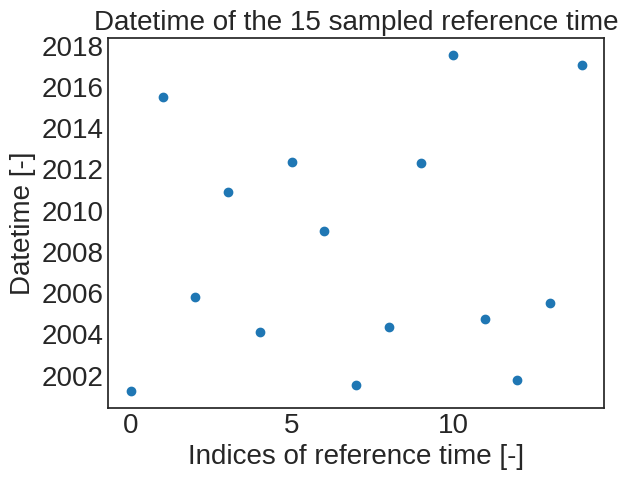

In [24]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
plot_sampled_datetime (df_sampled_time, extracted_data_loc)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "plot_sampled_datetime" computing time: {:.3f} s'.format(module_end_time - module_start_time))

# Read Quantities in a Selected Data File

## Read the Data in a Specified or Randomly Selected File

In [25]:
prescribe_file = True
if prescribe_file:
    data_file_to_read = 'wrf_2018-11-07_16.nc'
    timestamp_to_read = data_file_to_read.split('_')[1] + '_' + \
                        data_file_to_read.split('_')[2].split('.')[0]
else:
    random_ind_of_downsampled_files = random.choice(range(len(sampled_file_indices)))
    file_ind_to_read = sampled_file_indices[random_ind_of_downsampled_files]
    data_file_to_read = sampled_data_files[random_ind_of_downsampled_files]
    timestamp_to_read = sampled_time_stamps[random_ind_of_downsampled_files]

In [26]:
data_file_to_read, timestamp_to_read

('wrf_2018-11-07_16.nc', '2018-11-07_16')

In [27]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
data_at_timestamp = read_single_data_file (data_files_location, data_file_to_read, timestamp_to_read)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "read_single_data_file" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Module memory consumed: 115.242 MB
Module "read_single_data_file" computing time: 3.795 s


## Processing Elevation Data into Pos, Neg, and Zero

In [28]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
data_at_timestamp = process_elevation_at_timestamp (data_at_timestamp)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "process_elevation_at_timestamp" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Module memory consumed: 0.000 MB
Module "process_elevation_at_timestamp" computing time: 0.004 s


# Get and Plot Grid Indices (All and Considerable)

## Get Grid Indices

In [29]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
grid_indices_all, grid_indices_valid, grid_indices_all_flat, grid_indices_valid_flat = \
                        get_grid_indices_all (data_files_location, sampled_file_indices, \
                                              sampled_data_files, sampled_time_stamps, \
                                              x_clip, y_clip, \
                                              j_nevada, i_nevada, j_anchor, i_anchor, remove_nevada)

module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "get_grid_indices_all" computing time: {:.3f} s'.format(module_end_time - module_start_time))


Getting all the grid indices from a randomly selcted file...
The selected file is: wrf_2005-07-07_00.nc
Module memory consumed: 29.672 MB
Module "get_grid_indices_all" computing time: 0.482 s


## Reconstruct Grid Indices

In [30]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
grid_indices_valid_reconst, grid_indices_valid_bool, valid_grid_ind_to_coord = \
                reconstruct_valid_grid_indices (grid_indices_valid_flat, data_at_timestamp)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "reconstruct_valid_grid_indices" computing time: {:.3f} s'.format(module_end_time - module_start_time))


Reconstructing valid grid indices...
Module memory consumed: 4.973 MB
Module "reconstruct_valid_grid_indices" computing time: 0.035 s


## Plot Grid Indices

Module memory consumed: 5.082 MB
Module "plot_contours_of_indices" computing time: 0.681 s


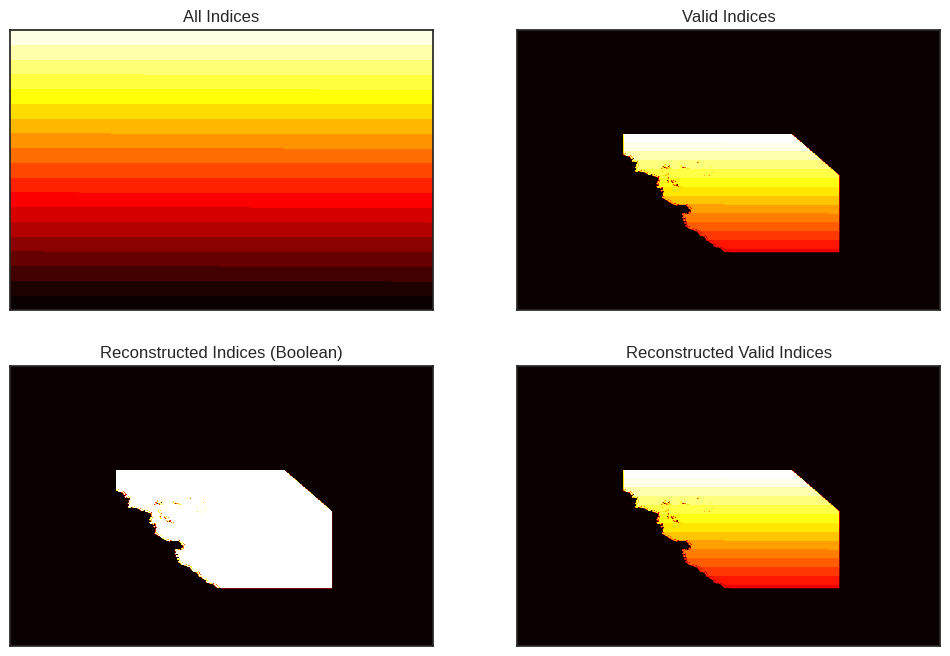

In [31]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
plot_contours_of_indices (data_at_timestamp, grid_indices_all, grid_indices_valid, \
                          grid_indices_valid_bool, grid_indices_valid_reconst, \
                          extracted_data_loc)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "plot_contours_of_indices" computing time: {:.3f} s'.format(module_end_time - module_start_time))

In [32]:
#len(grid_indices_valid_flat)

30489

# Plot Quantities in the Selected Data File

## Plot the Contours of QoIs for the Data Just Read Above

In [33]:
qoi_to_plot = ['HGT', 'HGT_UPD', 'U10', 'V10', 'FMC_1hr', 'FMC_10hr', 'FMC_100hr', 'T2', 'RH', 'PRECIP', 'PSFC', 'SWDOWN']

### Unmasked Data

Module memory consumed: 69.297 MB
Module "plot_contours_at_timestamp" computing time: 2.990 s


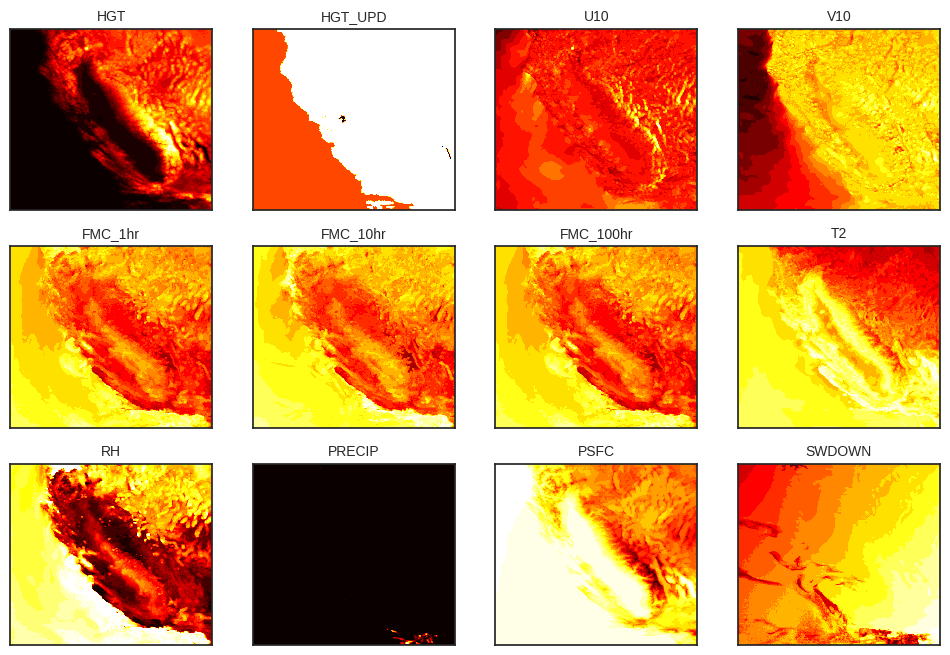

In [34]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
plot_contours_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc, grid_indices_valid, masked = False)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "plot_contours_at_timestamp" computing time: {:.3f} s'.format(module_end_time - module_start_time))

### Masked Data

Module memory consumed: 2.371 MB
Module "plot_contours_at_timestamp" computing time: 1.653 s


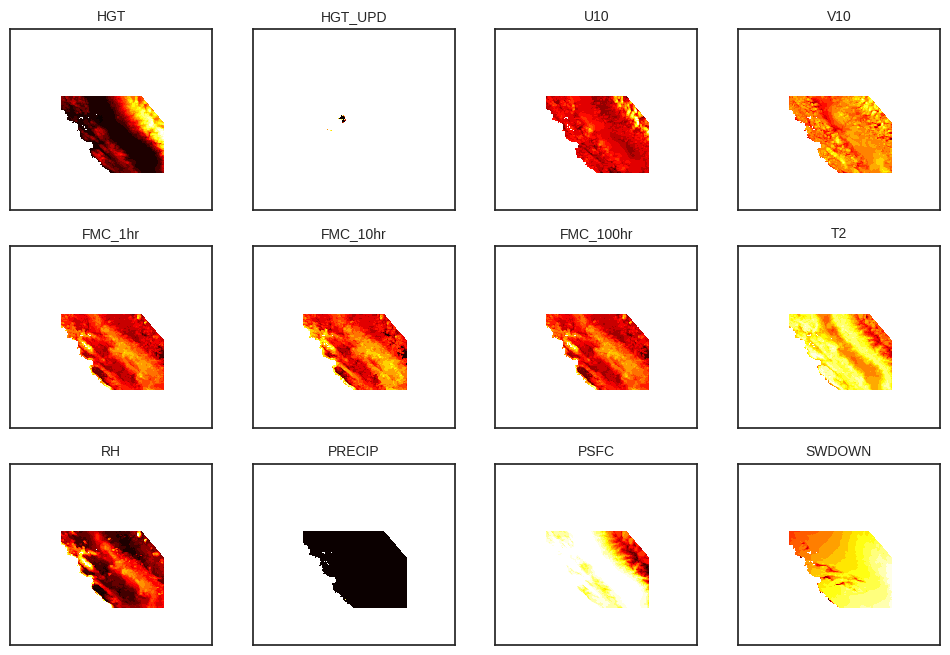

In [35]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
plot_contours_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc, grid_indices_valid, masked = True)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "plot_contours_at_timestamp" computing time: {:.3f} s'.format(module_end_time - module_start_time))

## Plot the PDFs of QoIs for the Data Just Read Above

In [36]:
qoi_to_plot = ['HGT', 'Q2', 'U10', 'V10', 'FMC_1hr', 'FMC_10hr', 'FMC_100hr', 'T2', 'RH', 'PRECIP', 'PSFC', 'SWDOWN']

Module memory consumed: 0.129 MB
Module "plot_pdf_at_timestamp" computing time: 1.845 s


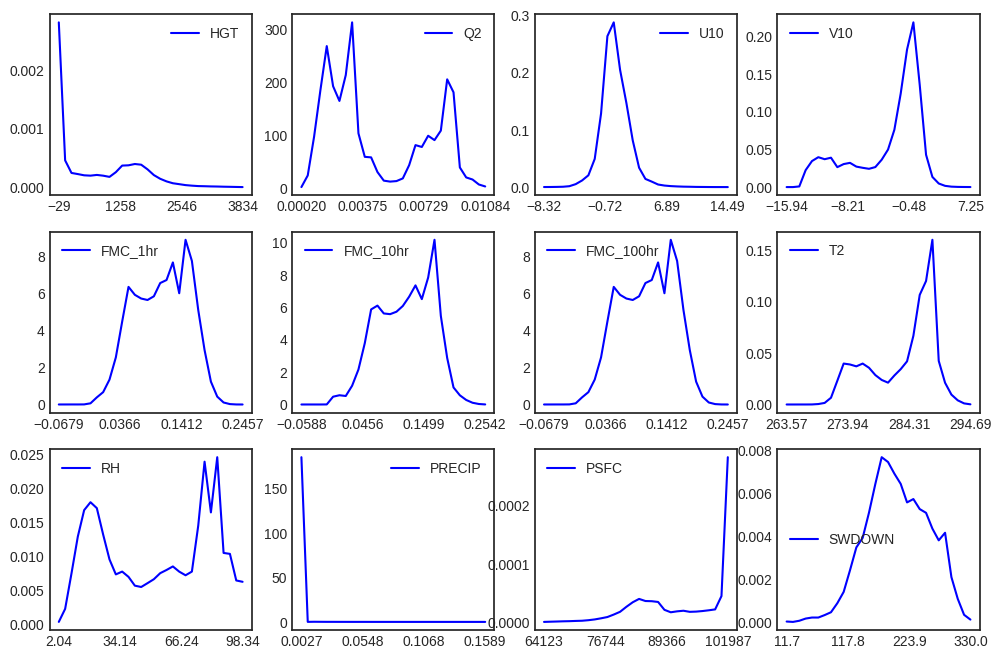

In [37]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
plot_pdf_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "plot_pdf_at_timestamp" computing time: {:.3f} s'.format(module_end_time - module_start_time))

## Plot the Contours of QoIs With Colorbars

In [38]:
qoi_to_plot = qoi_to_plot = ['FMC_1hr', 'FMC_10hr', 'FMC_100hr']
cont_levels_count = 31

Module memory consumed: 7.965 MB
Module "plot_contours_at_timestamp2" computing time: 2.265 s


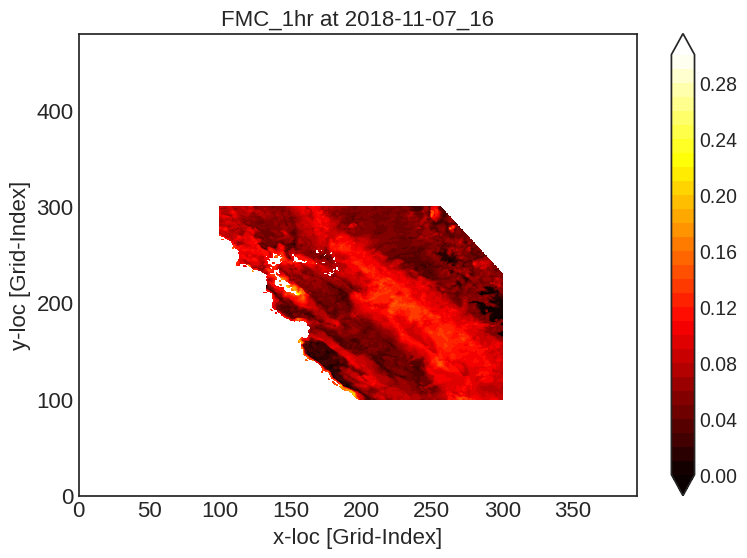

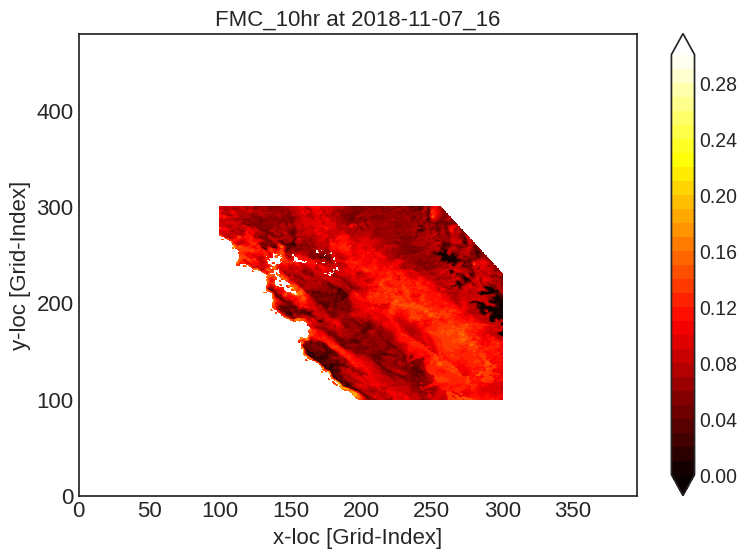

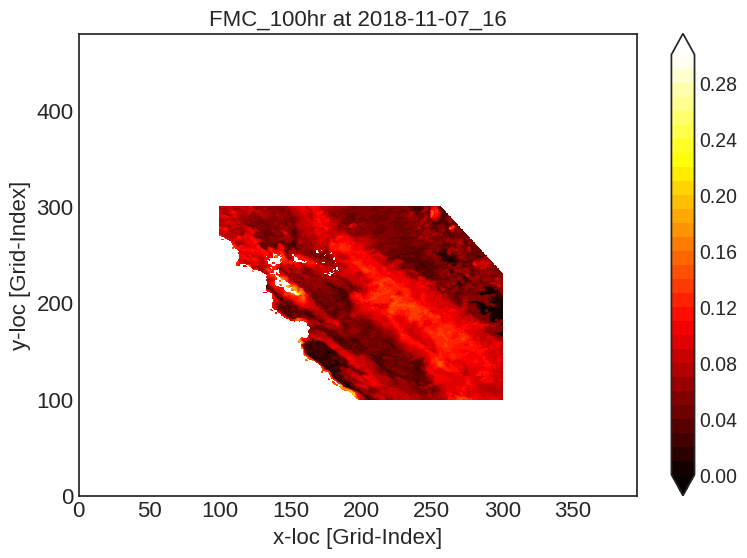

In [39]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
plot_contours_at_timestamp2 (data_at_timestamp, timestamp_to_read, qoi_to_plot, extracted_data_loc, grid_indices_valid, cont_levels_count, masked = True, qoi_cont_range = [0, 0.3])
#plot_contours_at_timestamp2 (data_at_timestamp, timestamp_to_read, qoi_to_plot, extracted_data_loc, grid_indices_valid, cont_levels_count, masked = True)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "plot_contours_at_timestamp2" computing time: {:.3f} s'.format(module_end_time - module_start_time))

# Sample and Plot Grid Indices for Each Sampled Ref Time

## Sample Grid Indices

In [40]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
grid_indices_selected, j_indices_selected, i_indices_selected = \
    sample_grid_indices (sampled_file_indices, percent_grid_points_to_use, \
                         grid_indices_valid_flat, valid_grid_ind_to_coord)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "sample_grid_indices" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Selecting 2 grid points (approx 0.0063131313 % of a total of 30489 considerable/valid grid points)

Module memory consumed: 0.000 MB
Module "sample_grid_indices" computing time: 0.041 s


## Plot Sampled Grid Indices

Module memory consumed: 0.141 MB
Module "plot_sampled_grid_points" computing time: 0.582 s


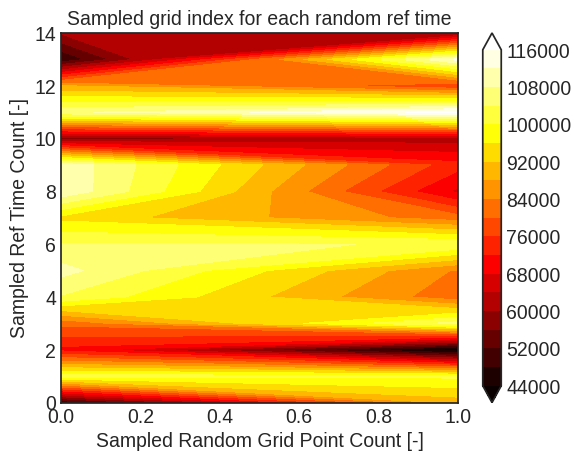

In [41]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
plot_sampled_grid_points (grid_indices_selected, extracted_data_loc)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "plot_sampled_grid_points" computing time: {:.3f} s'.format(module_end_time - module_start_time))

## Plot Sampled Grid Indices in 3D

Module memory consumed: 0.004 MB
Module "plot_sampled_grid_points_3D" computing time: 0.699 s


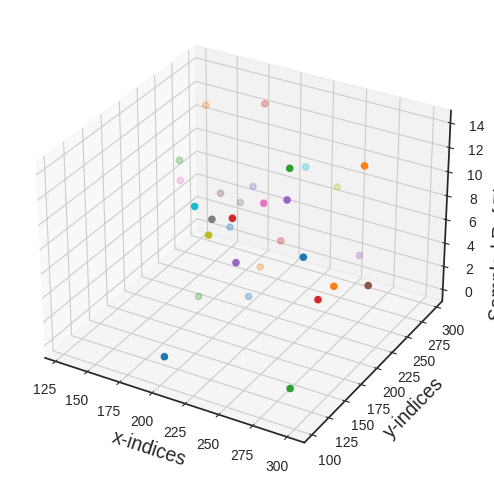

In [42]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
plot_sampled_grid_points_3D (j_indices_selected, i_indices_selected, extracted_data_loc, (6, 6))
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "plot_sampled_grid_points_3D" computing time: {:.3f} s'.format(module_end_time - module_start_time))

# Create a Dict of Time Indices and Grid Indices

In [43]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
time_grid_indices_list_dict, time_grid_indices_list_count, time_grid_indices_set_dict, time_grid_indices_set_count = \
    create_time_grid_indices_map (sampled_file_indices, history_file_indices, grid_indices_selected)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "create_time_grid_indices_map" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Module memory consumed: 0.000 MB
Module "create_time_grid_indices_map" computing time: 0.002 s


In [44]:
#len(time_grid_indices_list_dict.keys())

In [45]:
#len(time_grid_indices_set_dict.keys())

In [46]:
#time_grid_indices_list_dict
#time_grid_indices_list_count
#time_grid_indices_set_dict
#time_grid_indices_set_count

# Read Files At All Possible Time Indices (Ref + History)

## Read Data at All Times

In [47]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss

file_indices_to_read = list(time_grid_indices_list_dict.keys())
data_files_to_read, time_stamps_to_read, file_indices_data_dict = \
                read_data_all_possible_times (file_indices_to_read, data_files_list, \
                                             data_files_location)

module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "read_data_all_possible_times" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Read a total of 75 files ( ref time + history)
Module memory consumed: 1960.715 MB
Module "read_data_all_possible_times" computing time: 21.943 s


## Save Data In a Pickle File

In [48]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
save_data_read_at_all_possible_times (file_indices_to_read, data_files_to_read, \
                                      time_stamps_to_read, file_indices_data_dict, \
                                      extracted_data_loc, collection_of_read_data_files)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "save_data_read_at_all_possible_times" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Wrote all the read data files in "data_train_test_extracted_00_files_read.pkl" at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted/data_train_test_extracted_00"
Module memory consumed: 3.828 MB
Module "save_data_read_at_all_possible_times" computing time: 405.450 s


## Delete Data No Longer Needed To Free Memory

In [49]:
global_final_memory = process.memory_info().rss
global_memory_consumed = global_final_memory - global_initial_memory
print('Total memory consumed so far: {:.3f} MB'.format(global_memory_consumed/(1024*1024)))

print('Deleting Some Variables')
del file_indices_data_dict

global_final_memory = process.memory_info().rss
global_memory_consumed = global_final_memory - global_initial_memory
print('Total memory consumed so far: {:.3f} MB'.format(global_memory_consumed/(1024*1024)))

Total memory consumed so far: 2230.184 MB
Deleting Some Variables
Total memory consumed so far: 261.512 MB


## Read Data at All Possible Times Saved in a Pickle File

In [50]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
collection_of_read_data = read_data_from_pickle_all_possible_times (extracted_data_loc, \
                                                              collection_of_read_data_files)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "read_data_from_pickle_all_possible_times" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Reading the picke file "data_train_test_extracted_00_files_read.pkl" at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted/data_train_test_extracted_00"
Module memory consumed: 862.637 MB
Module "read_data_from_pickle_all_possible_times" computing time: 1.655 s


In [51]:
#collection_of_read_data['file_indices_data_dict'].keys()

## Plot Data in a Few Files

In [52]:
qoi_to_plot = ['HGT', 'HGT_UPD', 'U10', 'V10', 'FMC_1hr', 'FMC_10hr', 'FMC_100hr', 'T2', 'RH', 'PRECIP', 'PSFC', 'SWDOWN']

In [53]:
'''
num_files = 1
file_indices_data_dict = collection_of_read_data['file_indices_data_dict']
file_indices_to_read = list(file_indices_data_dict.keys())
for file_index_to_read in file_indices_to_read[0:num_files]:
    data_at_timestamp = file_indices_data_dict[file_index_to_read]
    plot_contours_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc, \
                                grid_indices_valid, masked = True)
'''

"\nnum_files = 1\nfile_indices_data_dict = collection_of_read_data['file_indices_data_dict']\nfile_indices_to_read = list(file_indices_data_dict.keys())\nfor file_index_to_read in file_indices_to_read[0:num_files]:\n    data_at_timestamp = file_indices_data_dict[file_index_to_read]\n    plot_contours_at_timestamp (data_at_timestamp, qoi_to_plot, extracted_data_loc,                                 grid_indices_valid, masked = True)\n"

# Extract and Save Data at The Sampled Time and Grid Points

## Extract Data at The Sampled Time and Grid Points

In [54]:
data_at_times = collection_of_read_data['file_indices_data_dict']
#data_at_times.keys()

In [55]:
module_start_time = timer()
module_initial_memory = process.memory_info().rss
df = create_dataframe_FM_atm_data (data_at_times, \
                                   sampled_file_indices, history_file_indices, \
                                   sampled_time_stamps, history_interval, \
                                   grid_indices_selected, \
                                   j_indices_selected, i_indices_selected)
module_final_memory = process.memory_info().rss
module_end_time = timer()
module_memory_consumed = module_final_memory - module_initial_memory
print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
print('Module "create_dataframe_FM_atm_data" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Module memory consumed: 0.000 MB
Module "create_dataframe_FM_atm_data" computing time: 0.011 s


In [56]:
#df.head(5)

## Save The Data Extracted  at Sampled Time and Grid Points

In [57]:
df.to_pickle(os.path.join(extracted_data_loc, extracted_data_file_name))

## Load and Test The Extracted Data Saved in Pickle File

In [58]:
df_from_pickle = pd.read_pickle(os.path.join(extracted_data_loc, extracted_data_file_name))
df_from_pickle.head(5)

,FM_time_ind,FM_ts,his_time_ind,grid_ind,j_ind,i_ind,FM_10hr,FM_100hr,HGT,U10[-8hr],...,T2[-4hr],RH[-4hr],PREC[-4hr],SWDOWN[-4hr],U10[-2hr],V10[-2hr],T2[-2hr],RH[-2hr],PREC[-2hr],SWDOWN[-2hr]
0,10966,2001-04-01_22,"[10958, 10960, 10962, 10964]",48108,121,192,0.059180,0.042167,330.000519,1.085739,...,294.149536,26.626482,0.0,804.674927,0.950183,1.814375,296.625458,29.391632,0.0,897.743896
1,10966,2001-04-01_22,"[10958, 10960, 10962, 10964]",89698,226,202,0.113184,0.077240,39.137691,1.083485,...,292.575195,43.297291,0.0,679.392334,3.834279,-1.838778,295.184723,34.610928,0.0,905.250244
2,135892,2015-07-03_05,"[135884, 135886, 135888, 135890]",102025,257,253,0.123491,0.144076,2246.286377,3.439481,...,295.835419,31.723768,0.0,391.583527,2.347974,-1.675197,292.947174,35.181675,0.0,9.903998
3,135892,2015-07-03_05,"[135884, 135886, 135888, 135890]",100781,254,197,0.102192,0.127412,76.925560,2.342730,...,304.328186,28.258524,0.0,305.835693,3.960633,0.071915,297.648193,45.357258,0.0,38.892750
4,50909,2005-10-22_05,"[50901, 50903, 50905, 50907]",70676,178,188,0.114710,0.119024,684.114746,1.902958,...,292.221558,46.811558,0.0,15.038418,-0.537711,-1.591781,291.438568,44.222336,0.0,0.000000


# Save Other Relevant Info in A CSV File

In [59]:
data_for_csv = { 'max_history_to_consider':    [max_history_to_consider],
                 'history_interval':           [history_interval],
                 'num_hist_indices':           [len(history_file_indices[0])],
                 'num_total_files':            [len(data_files_list)],
                 'percent_files_to_use':       [percent_files_to_use],
                 'num_sampled_times':          [grid_indices_selected.shape[0]],
                 'num_data_files_to_read':     [len(data_files_to_read)],
                 'num_grid_points_sn':         [grid_indices_all.shape[0]],
                 'num_grid_points_we':         [grid_indices_all.shape[1]],
                 'num_total_grid_points':      [len(grid_indices_all_flat)],
                 'num_valid_grid_points':      [len(grid_indices_valid_flat)],
                 'percent_grid_points_to_use': [percent_grid_points_to_use],
                 'num_sampled_grid_points':    [grid_indices_selected.shape[1]],
                 'num_data_points':            [len(df)]               
}
tabulated_data = pd.DataFrame(data_for_csv)
tabulated_data.to_csv(os.path.join(extracted_data_loc, tab_data_file_name), index = False)

In [60]:
tabulated_data

,max_history_to_consider,history_interval,num_hist_indices,num_total_files,percent_files_to_use,num_sampled_times,num_data_files_to_read,num_grid_points_sn,num_grid_points_we,num_total_grid_points,num_valid_grid_points,percent_grid_points_to_use,num_sampled_grid_points,num_data_points
0,8,2,4,184103,0.008178,15,75,480,396,190080,30489,0.006313,2,30


# Extract Fire Data

## Read Fire Data

In [61]:
if extract_fire_data:
    module_start_time = timer()
    module_initial_memory = process.memory_info().rss

    fire_time_indices, fire_data = read_fire_data (\
                                fire_time_indices, max_history_to_consider, history_interval, \
                                data_files_list_all, data_files_location)

    module_final_memory = process.memory_info().rss
    module_end_time = timer()
    module_memory_consumed = module_final_memory - module_initial_memory
    print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
    print('Module "read_fire_data" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Read a total of 5 files ( ref time + history)
Read a total of 5 files ( ref time + history)
Module memory consumed: 258.418 MB
Module "read_fire_data" computing time: 3.327 s


## Create DataFrame for Fire Data

In [62]:
if extract_fire_data:
    module_start_time = timer()
    module_initial_memory = process.memory_info().rss
    fire_data_extracted = dict()

    for fire_name in fire_time_indices.keys():
        data_at_times = fire_data[fire_name]['fire_file_indices_data_dict']
        df_fire = create_dataframe_FM_atm_data_fire (fire_name, fire_time_indices, data_at_times, \
                                                     history_interval, \
                                                     grid_indices_valid_flat, valid_grid_ind_to_coord)
        fire_data_extracted[fire_name] = df_fire

    module_final_memory = process.memory_info().rss
    module_end_time = timer()
    module_memory_consumed = module_final_memory - module_initial_memory
    print('Module memory consumed: {:.3f} MB'.format(module_memory_consumed/(1024*1024)))
    print('Module "create_dataframe_FM_atm_data_fire" computing time: {:.3f} s'.format(module_end_time - module_start_time))

Module memory consumed: 6.961 MB
Module "create_dataframe_FM_atm_data_fire" computing time: 1.867 s


## Save DataFrame for Fire Data

In [63]:
if extract_fire_data:
    fire_data_file_handle = open(os.path.join(fire_data_loc, fire_data_file_name), 'wb')
    pickle.dump(fire_data_extracted, fire_data_file_handle)
    fire_data_file_handle.close()
    print('Wrote fire data in "{}" at "{}"'.format(fire_data_file_name, fire_data_loc))

Wrote fire data in "data_fire_extracted_00.pkl" at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted/data_fire_extracted_00"


## Load and Test The Extracted Fire Data Saved in Pickle File

In [64]:
if extract_fire_data:
    fire_data_file_handle = open(os.path.join(fire_data_loc, fire_data_file_name), 'rb')
    fire_data_pickled = pickle.load(fire_data_file_handle)
    fire_data_file_handle.close()
    print('Read fire data from "{}" at "{}"'.format(fire_data_file_name, fire_data_loc))

Read fire data from "data_fire_extracted_00.pkl" at "/p/lustre2/jha3/Wildfire/Wildfire_LDRD_SI/SJSU/01_WRF_Nelson_Data_Extracted/data_fire_extracted_00"


In [65]:
if extract_fire_data:
    fire_data_pickled['Woosley'].head(5)

## Delete Fire Data No Longer Needed

In [66]:
if extract_fire_data:
    del fire_data, data_at_times, fire_data_extracted

# Global End Time and Memory

In [67]:
global_final_memory = process.memory_info().rss
global_end_time = timer()
global_memory_consumed = global_final_memory - global_initial_memory
print('Total memory consumed: {:.3f} MB'.format(global_memory_consumed/(1024*1024)))
print('Total computing time: {:.3f} s'.format(global_end_time - global_start_time))
print('=========================================================================')
print("SUCCESS: Done Extraction of Data")

Total memory consumed: 1392.816 MB
Total computing time: 645.706 s
SUCCESS: Done Extraction of Data
